# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [4]:
import helper
data_dir = './data'

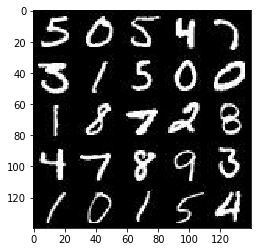

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

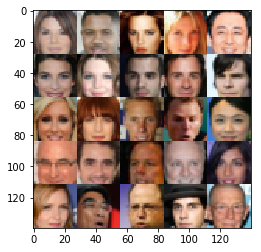

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (), name='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x56

        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112

        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x224

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*224)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 224))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x224 now
        
        x2 = tf.layers.conv2d_transpose(x1, 112, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x112 now
        
        #x3 = tf.layers.conv2d_transpose(x2, 56, 5, strides=2, padding='same')
        #x3 = tf.layers.batch_normalization(x3, training=is_train)
        #x3 = tf.maximum(alpha * x3, x3)
        # 28x28x56 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xchannel now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 10
    show_every=100
    sample_images=12
    
    tf.reset_default_graph()
        
    input_real, input_z, learning_rate_tf = model_inputs(
        image_width=data_shape[1],
        image_height=data_shape[2],
        image_channels=data_shape[3],
        z_dim=z_dim
    )

    out_channel_dim=data_shape[3]
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tf, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Rescale batch_images to be in range -1 to 1
                batch_images *= 2
                
                # Run optimizers
                _ = sess.run(
                    d_opt, 
                    feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        learning_rate_tf: learning_rate
                    }
                )
                _ = sess.run(
                    g_opt, 
                    feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        learning_rate_tf: learning_rate
                    }
                )
                _ = sess.run(
                    g_opt, 
                    feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        learning_rate_tf: learning_rate
                    }
                )

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, sample_images, input_z, out_channel_dim, data_image_mode)
               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2353... Generator Loss: 0.1586
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 1.3377
Epoch 1/2... Discriminator Loss: 1.3758... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.5874... Generator Loss: 0.3011
Epoch 1/2... Discriminator Loss: 1.0969... Generator Loss: 1.0532
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.3583
Epoch 1/2... Discriminator Loss: 1.3946... Generator Loss: 1.6828
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 0.5679
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 0.7318


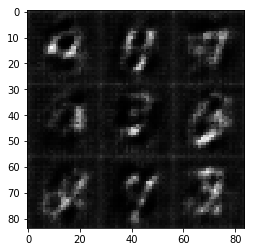

Epoch 1/2... Discriminator Loss: 1.1148... Generator Loss: 0.5986
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 1.8735
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.5931
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.0657
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.0987
Epoch 1/2... Discriminator Loss: 0.9873... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 1.2390... Generator Loss: 0.5092
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 0.6511
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 0.8484


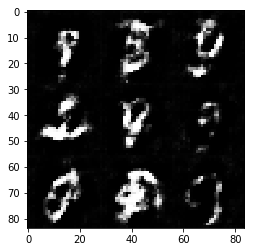

Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 0.7782... Generator Loss: 1.3627
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.4509
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.3991
Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 1.6452
Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.4899... Generator Loss: 0.3264


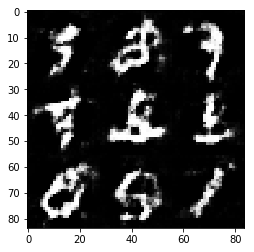

Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.4926
Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 0.7728
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.1310... Generator Loss: 0.7210
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.6471
Epoch 1/2... Discriminator Loss: 0.9134... Generator Loss: 1.1609
Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 0.9311
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.0564... Generator Loss: 0.6428


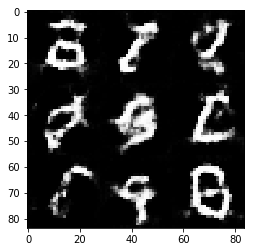

Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 1.6022
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 1.2526
Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 0.5524
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.2794
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 1.3283
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.6567... Generator Loss: 0.2743


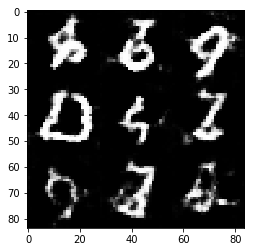

Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.3785
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.7184
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 0.9917
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 0.9380... Generator Loss: 0.9786
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.4546


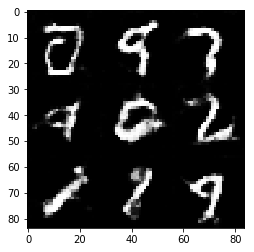

Epoch 1/2... Discriminator Loss: 0.7672... Generator Loss: 1.1314
Epoch 1/2... Discriminator Loss: 1.8234... Generator Loss: 0.2507
Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 0.5477
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 1.0279
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 0.8322
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 1.0974
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 0.5675
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 0.9798... Generator Loss: 0.7837


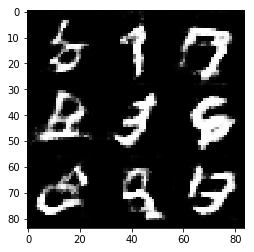

Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 0.4554
Epoch 1/2... Discriminator Loss: 0.8821... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 0.8682... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 1.0552... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 1.2406... Generator Loss: 0.4668
Epoch 1/2... Discriminator Loss: 1.7913... Generator Loss: 0.2398


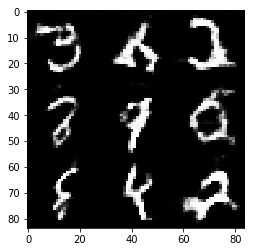

Epoch 1/2... Discriminator Loss: 0.9627... Generator Loss: 0.6550
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 0.8552
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.3873
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 0.8152... Generator Loss: 1.0096
Epoch 1/2... Discriminator Loss: 4.7141... Generator Loss: 0.0201
Epoch 1/2... Discriminator Loss: 0.9139... Generator Loss: 0.7725
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 1.0923


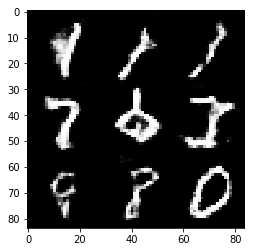

Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 0.2947
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 1.4704... Generator Loss: 0.3342
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.4146
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 0.4168
Epoch 2/2... Discriminator Loss: 1.4465... Generator Loss: 0.3760
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 1.0782
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.5723


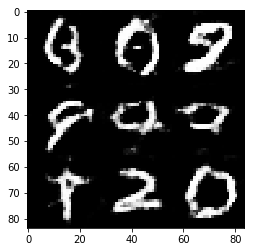

Epoch 2/2... Discriminator Loss: 0.7443... Generator Loss: 1.0617
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 0.7039
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.5455
Epoch 2/2... Discriminator Loss: 1.6647... Generator Loss: 0.3037
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 0.5415
Epoch 2/2... Discriminator Loss: 2.5692... Generator Loss: 0.1816
Epoch 2/2... Discriminator Loss: 1.0812... Generator Loss: 0.7142
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 0.8658
Epoch 2/2... Discriminator Loss: 0.8355... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 0.6191


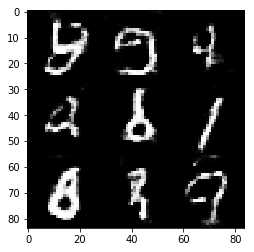

Epoch 2/2... Discriminator Loss: 1.6159... Generator Loss: 0.2825
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 0.5726
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.5860
Epoch 2/2... Discriminator Loss: 0.7488... Generator Loss: 0.9480
Epoch 2/2... Discriminator Loss: 1.3416... Generator Loss: 0.4536
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.4473
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.4568
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.4508
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.4997
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 0.9051


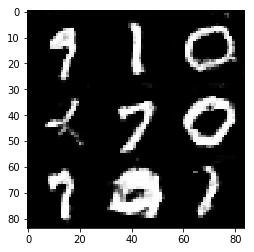

Epoch 2/2... Discriminator Loss: 1.2997... Generator Loss: 3.4569
Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 0.7753
Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 0.8967... Generator Loss: 0.7971
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 0.6689
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 1.7623... Generator Loss: 0.2631
Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 2.5340
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 0.9696
Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 0.6876


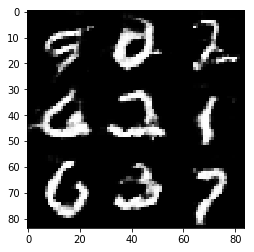

Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 0.5885
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 0.7379
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 0.5878
Epoch 2/2... Discriminator Loss: 0.9419... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 0.8003
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 0.7286
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 0.6815
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.3661
Epoch 2/2... Discriminator Loss: 1.0036... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 0.6472


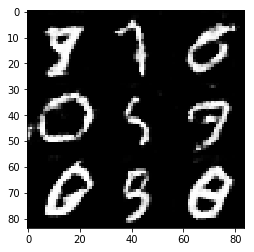

Epoch 2/2... Discriminator Loss: 1.5325... Generator Loss: 0.3536
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 0.5918
Epoch 2/2... Discriminator Loss: 1.2446... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.3958
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 0.8520
Epoch 2/2... Discriminator Loss: 0.6528... Generator Loss: 1.1166
Epoch 2/2... Discriminator Loss: 7.0233... Generator Loss: 7.5927
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 1.1755
Epoch 2/2... Discriminator Loss: 0.9115... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 1.0004... Generator Loss: 0.6324


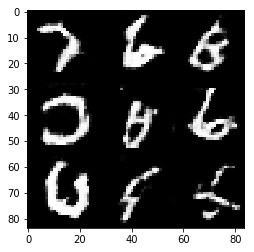

Epoch 2/2... Discriminator Loss: 0.5626... Generator Loss: 1.2692
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 0.8116... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 0.6483
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 0.7463
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 2.8169
Epoch 2/2... Discriminator Loss: 0.7946... Generator Loss: 1.0145
Epoch 2/2... Discriminator Loss: 0.6932... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 0.4452
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.4675


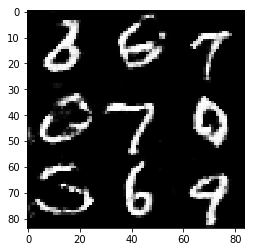

Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.6930
Epoch 2/2... Discriminator Loss: 0.9786... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 0.6664... Generator Loss: 1.2541
Epoch 2/2... Discriminator Loss: 0.6756... Generator Loss: 0.9598
Epoch 2/2... Discriminator Loss: 1.2699... Generator Loss: 0.4839
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 0.6778... Generator Loss: 1.3150
Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 0.6840
Epoch 2/2... Discriminator Loss: 0.6582... Generator Loss: 1.0281


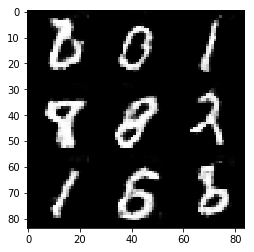

Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.4038
Epoch 2/2... Discriminator Loss: 0.8341... Generator Loss: 0.8462
Epoch 2/2... Discriminator Loss: 1.1600... Generator Loss: 0.5393
Epoch 2/2... Discriminator Loss: 1.8308... Generator Loss: 3.3924
Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 2.6703
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 1.0916... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 0.6281
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.4036
Epoch 2/2... Discriminator Loss: 0.6957... Generator Loss: 1.1636


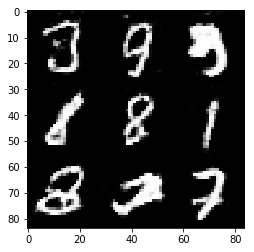

Epoch 2/2... Discriminator Loss: 1.1207... Generator Loss: 0.5663
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 1.1433... Generator Loss: 0.5491
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.4568
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 0.4928
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 0.6149


IndexError: list index out of range

In [46]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0022... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.9907... Generator Loss: 2.9842
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.8474... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 2.0369... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.7214... Generator Loss: 0.5970


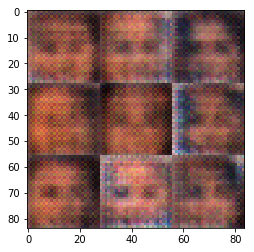

Epoch 1/1... Discriminator Loss: 2.2017... Generator Loss: 0.3170
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.6458... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.8194... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.6149... Generator Loss: 0.5688


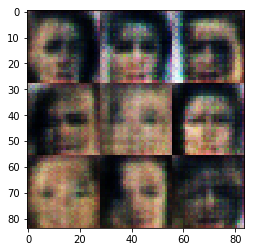

Epoch 1/1... Discriminator Loss: 1.8629... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 2.3083... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.6719... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.7197... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.5322


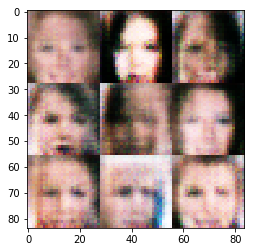

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.5925... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.6871... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.5640


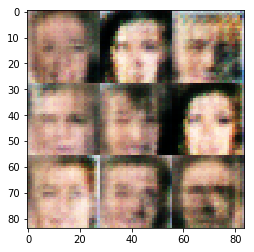

Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.7556... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.6779... Generator Loss: 0.6571


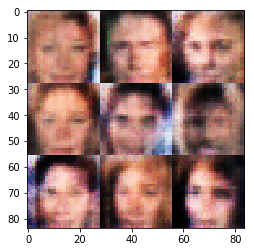

Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.7540


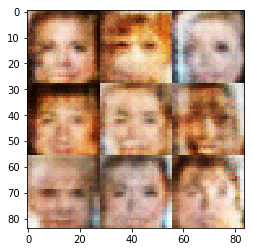

Epoch 1/1... Discriminator Loss: 1.6722... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6449


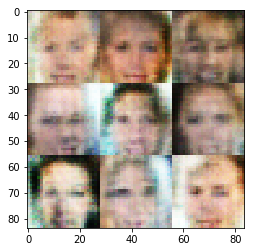

Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.5917


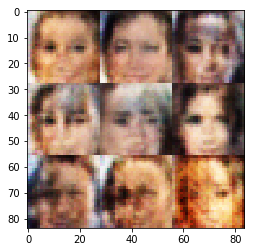

Epoch 1/1... Discriminator Loss: 1.6593... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6946


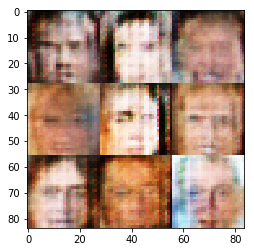

Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.5452


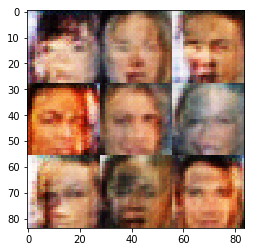

Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.6579


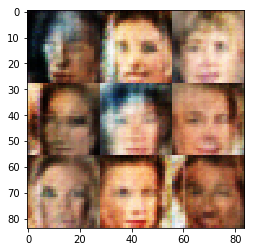

Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7162


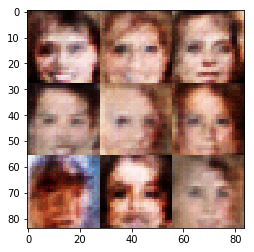

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4910... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6964


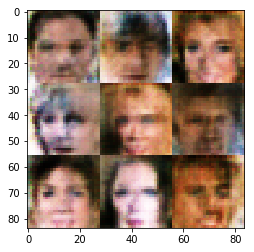

Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.6678... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.6127... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6476


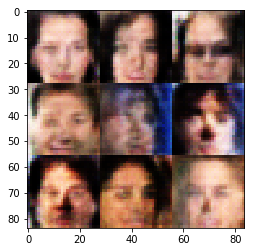

Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.6070... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6489


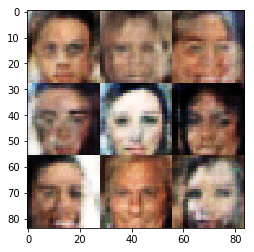

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.6272... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7238


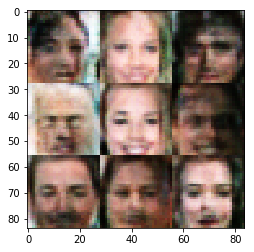

Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.8721... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 1.0697... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.7829... Generator Loss: 0.3195


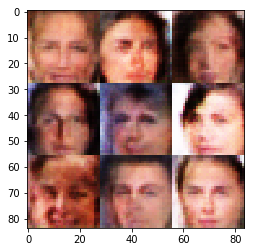

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.5833


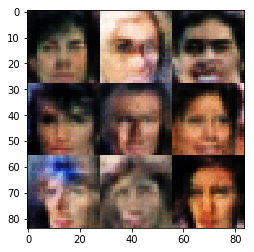

Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7445


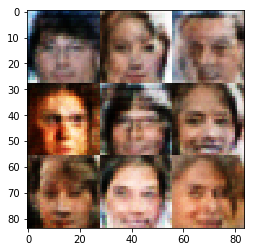

Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.6937


IndexError: list index out of range

In [47]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.